# This notebook demonstrates how to train a score-based diffusion model on the MNIST dataset. 

We will introduce MNIST, show how to download the dataset, train a score-based diffusion model on MNSIT, and evaluate the quality of the samples generated by our trained modelusing the $\href{https://arxiv.org/abs/2402.04355}{\text{PQMass}}$ metric, introduced by Lemos et al. (2024).

In [1]:
# General Imports 
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
import os 

# Imports for Score Model
from score_models import ScoreModel, EnergyModel, NCSNpp, MLP, DDPM

# Imports for PQMass
from scipy.stats import norm, chi2, uniform
from pqm import pqm_chi2

# Imports for Nice Plotting
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200
plt.rc("font", **{"family": "serif", "serif": ["Computer Modern"]})
plt.rc("text", usetex=True)

# Create a Folder called MNIST_Checkpoint_Directory if it doesn't exist - This is used during training the diffusion model
# Define the directory path
checkpoint_dir = './MNIST_Checkpoint_Directory'

# Check if the directory exists, and if not, create it
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
    print(f"Directory '{checkpoint_dir}' created.")
else:
    print(f"Directory '{checkpoint_dir}' already exists.")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Directory './MNIST_Checkpoint_Directory' already exists.


# MNIST

The data we are going to be working with is called MNIST. It is a 60,000 training and 10,000 test images of handwritten digits from 0 to 9. All the images are grayscaled, meaning one channel, and each image is 28x28 pixels. It is widely used for benchmarking machine learning models due to its simplicity and ease of visualization.

In [12]:
def open_data(data_dir, num_samples=10000, train=True):
    # Define the transform to convert images to tensors
    transform = transforms.Compose([transforms.ToTensor()])
    
    # Load the MNIST dataset with the transform applied
    all_mnist = MNIST(data_dir, train=train, transform=transform, download=False)
    
    # Randomly select a subset of images
    total_samples = len(all_mnist)
    random_indices = torch.randperm(total_samples)[:num_samples]
    
    # Stack only the selected images
    dataset = torch.stack([all_mnist[i][0] for i in random_indices], dim=0)

    return dataset

class MNIST_datasets(torch.utils.data.Dataset):
    def __init__(self, data_dir, *args, num_samples=10000):
        self.args = args
        # Load training and test datasets
        self.dataset = open_data(data_dir=data_dir, num_samples=num_samples, train=True)
        self.dataset_test = open_data(data_dir=data_dir, num_samples=num_samples, train=False)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        data = []
        for i in range(1, len(self.datasets) + 1):
            data.append(self.datasets[f'dataset{i}'][idx].to(device))

        return data
    
# Set the data directory
data_dir = './data'

# Download MNIST
MNIST(data_dir, train=True, download=True, transform=transforms.ToTensor())
MNIST(data_dir, train=False, download=True, transform=transforms.ToTensor())

# Initialize the mult_datasets instance
dataset_instance = MNIST_datasets(data_dir=data_dir)

# Access both train and test datasets
train_data = dataset_instance.dataset
test_data = dataset_instance.dataset_test

# Diffusion Model Setup

Here we define the setup for a diffusion model such that it can be trained on all 60k MNIST grayscaled images. This is just an example of the hyperparameters and leave it for the reader to modify the hyperparameters as they see fit.

In [3]:
checkpoints_directory = './MNIST_Checkpoint_Directory'

net = NCSNpp(channels=1, dimensions=2, nf=128, ch_mult=[2, 2])
model = ScoreModel(model=net, beta_min=1e-2, beta_max=20).to(device)

model.fit(train_data.to(device), epochs=10, batch_size=128, learning_rate=1e-3, ema_decay = 0.999,
                   checkpoints_directory=checkpoints_directory)

Using the Variance Preserving SDE


Epoch 10 | Cost: 1.8e+01 |: 100%|██████████| 10/10 [02:07<00:00, 12.78s/it]

Finished training after 0.035 hours.


[162.28086529502386,
 38.11480836023258,
 27.26716512366186,
 23.280498987511745,
 20.737696273417413,
 19.808246214178546,
 19.183665178999117,
 18.101966061169588,
 18.22634054739264,
 18.268924833853035]

# Sampling

Now we have trained our model, we can generate samples and see what our model has learned

In [4]:
model.eval()

B = 10 # Number of samples you want to generate
dimensions = [1, 28, 28] # The spatial dimensions of MNIST; 1 channel (black and white), 28x28 pixels

# Generate samples from the trained model (steps is the number of Euler-Maruyama steps)
samples = model.sample(shape=[B, *dimensions], steps=1000)

Sampling from the prior | t = 0.0 | sigma = 4.5e-03| scale ~ 2.9e-01: 100%|██████████| 1000/1000 [00:10<00:00, 99.07it/s]


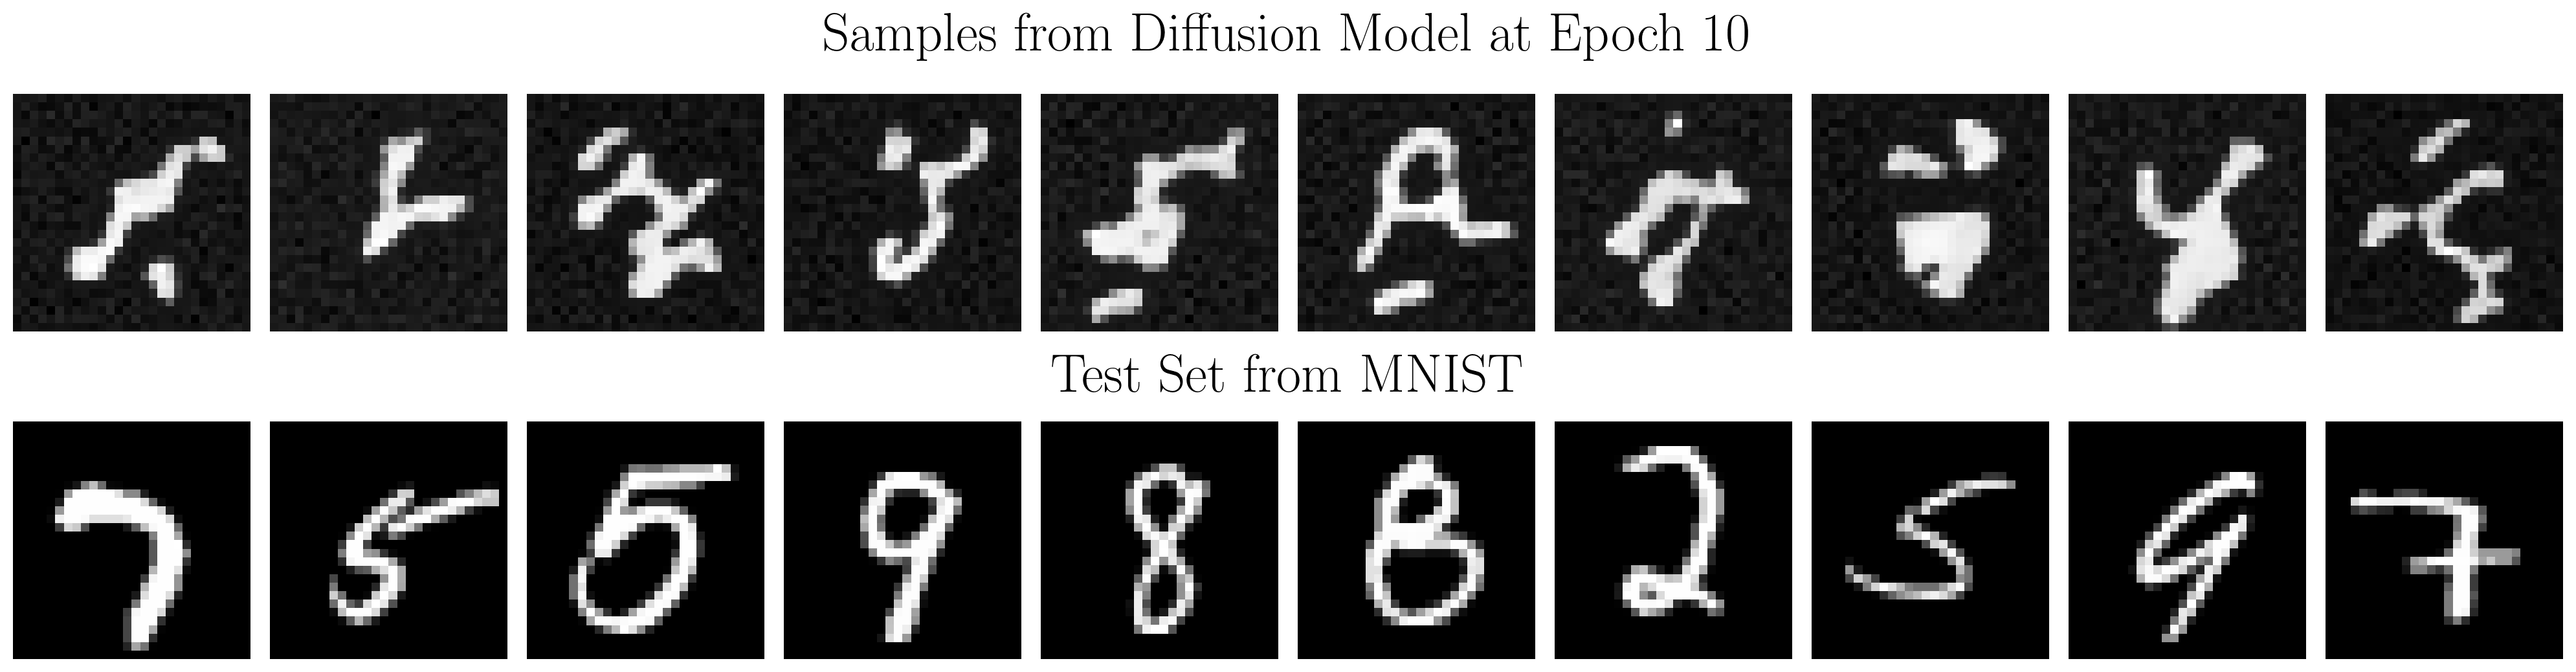

In [5]:
# Define the number of images you want to plot
B = 10

# Create a 2xB grid of subplots
fig, ax = plt.subplots(2, B, figsize=(20, 6))

# Plot the model's samples in the first row
for i in range(B):
    ax[0, i].imshow(samples[i, 0].cpu().detach().numpy(), cmap='gray')
    ax[0, i].axis('off')

# Plot the test images in the second row
for i in range(B):
    ax[1, i].imshow(test_data[i, 0].cpu().detach().numpy(), cmap='gray')
    ax[1, i].axis('off')

# Add row titles
fig.text(0.5, 0.92, 'Samples from Diffusion Model at Epoch 10', ha='center', fontsize=30)
fig.text(0.5, 0.48, 'Test Set from MNIST', ha='center', fontsize=30)

# Adjust spacing between subplots for better layout
plt.tight_layout()
plt.show()

Do these samples come from the same distribution as the test set? Has it learned the underlying distribution? How can you tell? There are statistical methods to evaluate if the samples come from the same distribution such as  $\href{https://arxiv.org/abs/2402.04355}{\text{PQMass}}$. This gives you a way of determining if the distrubution your model has learned is similar a test/validation distribution. In this case we use to compare the samples our model generatives to the test set of MNIST!

You need a lot of samples so we will load in 5k samples that have already been generated to show how PQMass works. Note that this is is the model with the same hyperparameters trained offline for 100 epochs that is in the folder.

In [6]:
# Samples from a pretrained model at Epoch 100 (can be found in here (link)) 
samples = torch.load('./Epoch_100_MNIST_1000_Samples_VP_NF_128_Ch_Mult_2_2_Batch_Size_128_LR_1e_3_ema_decay_0_999.pt', weights_only=False)
samples = samples.unsqueeze(1)  # Adds the channel dimension

We plot the samples to show what they look like verus the test set of MNIST. (Note that this is not the same epoch as from above so these samples look much better!)

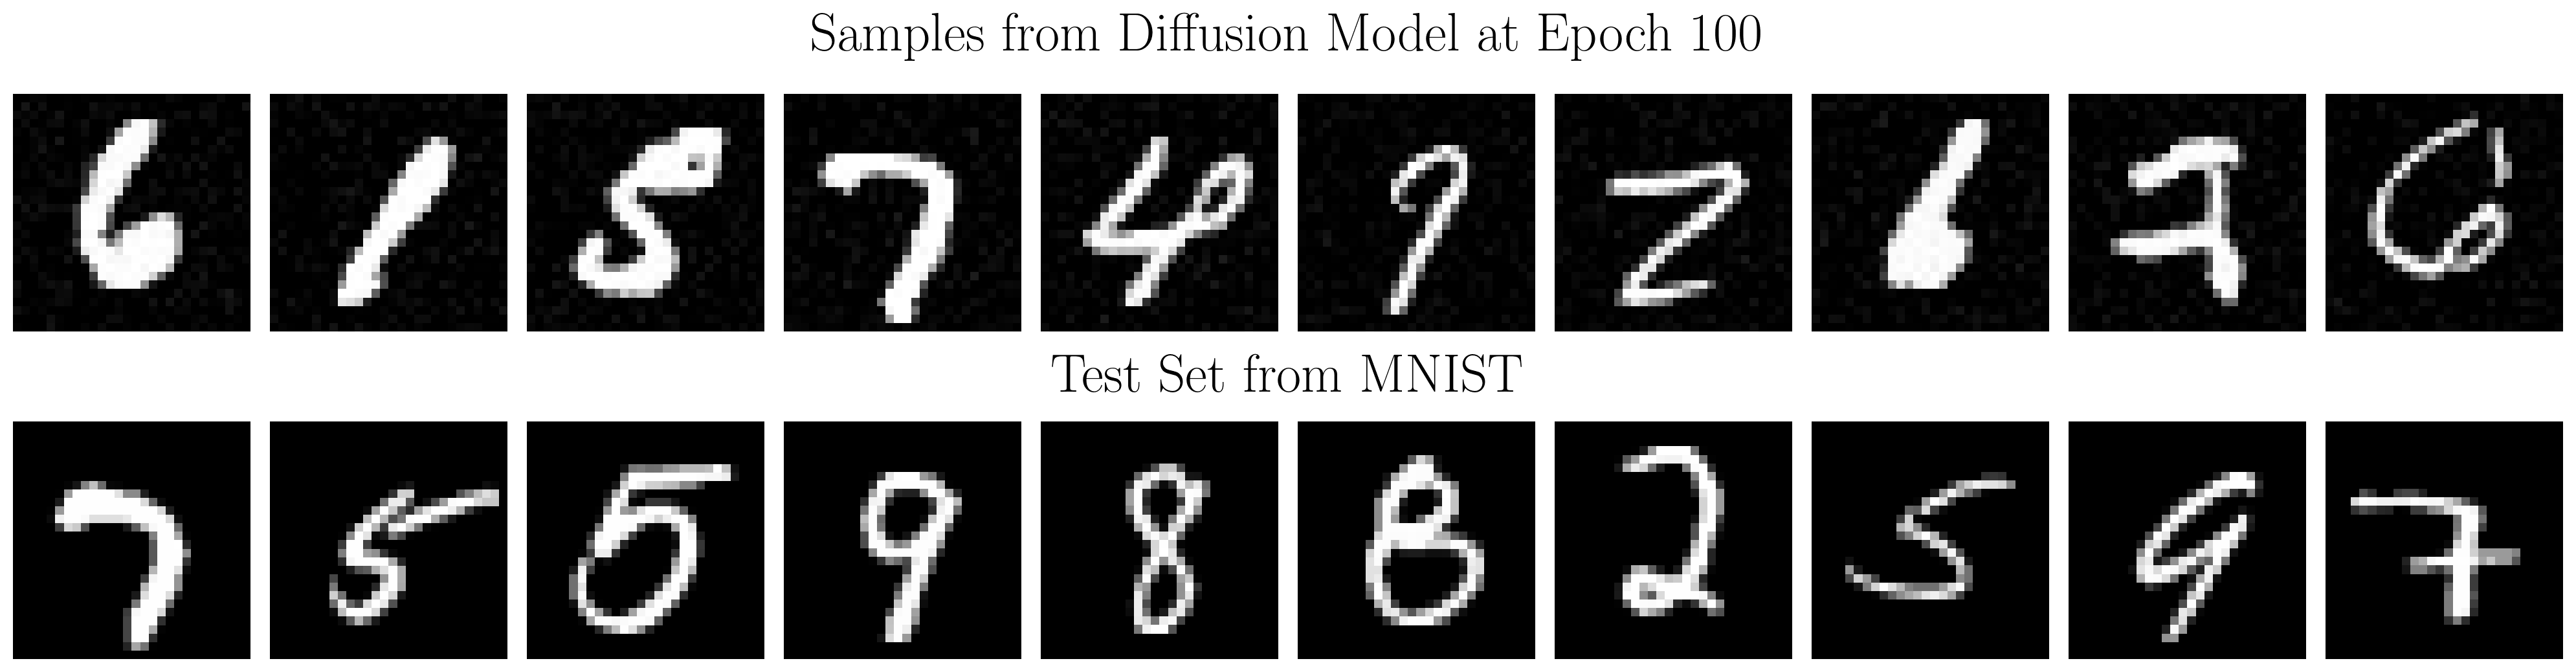

In [7]:
# Define the number of images you want to plot
B = 10

# Create a 2xB grid of subplots
fig, ax = plt.subplots(2, B, figsize=(20, 6))

# Plot the model's samples in the first row
for i in range(B):
    ax[0, i].imshow(samples[i, 0].cpu().detach().numpy(), cmap='gray')
    ax[0, i].axis('off')

# Plot the test images in the second row
for i in range(B):
    ax[1, i].imshow(test_data[i, 0].cpu().detach().numpy(), cmap='gray')
    ax[1, i].axis('off')

# Add row titles
fig.text(0.5, 0.92, 'Samples from Diffusion Model at Epoch 100', ha='center', fontsize=30)
fig.text(0.5, 0.48, 'Test Set from MNIST', ha='center', fontsize=30)

# Adjust spacing between subplots for better layout
plt.tight_layout()
plt.show()

In [8]:
# Normalize with respect to test_images as that is what we are comparing to
normalized_normalized_test_data = ((test_data - torch.min(test_data)) / (torch.max(test_data) - torch.min(test_data))) 
normalized_samples = ((samples - torch.min(test_data)) / (torch.max(test_data) - torch.min(test_data))) 

# Reshape
normalized_samples = normalized_samples.data.reshape(-1, 28*28)
normalized_normalized_test_data = normalized_normalized_test_data.data.reshape(-1, 28*28)

# PQMass

The way PQMass works is that given two distributions, $p$ and $q$, it randomly selects reference points from each dataset. Then it constructs $n_R$ Voronoi tesellations around those centers. Then based on the distribution of each dataset, the number of samples in a given region is counted. It follows that any given sample follows a Multinomial distribution, it can be in region A or any other region, in which the PQMass paper constructed a way to evaluate both a $\chi^2$ metric and a p-value to measure if the $p$ and $q$ come from the same distribution or not. For this notebook we use the $\chi^2$ metric.

In [9]:
zs = []
num_repeats = 35
n = len(samples) // num_repeats
m = len(test_data) // num_repeats

for i in range(num_repeats):
    for _ in range(num_repeats):
        z = pqm_chi2(normalized_samples[i*n:(i+1)*n].cpu(), normalized_normalized_test_data[i*m:(i+1)*m].cpu())
        zs.append(z)

print(np.median(zs), np.std(zs))

99.04893425663707 11.433193566118554


Above we show the median and the standard deviation but if you want to see another way of showcasing how in or out of distribution your samples are, you can plot them against the $\chi^2$ distribution. You want your samples (blue) to match the test distribuition (red). We show that the generated samples are well in distribution with the test set from MNIST meaning our model has learned the correct underlying distrubution!

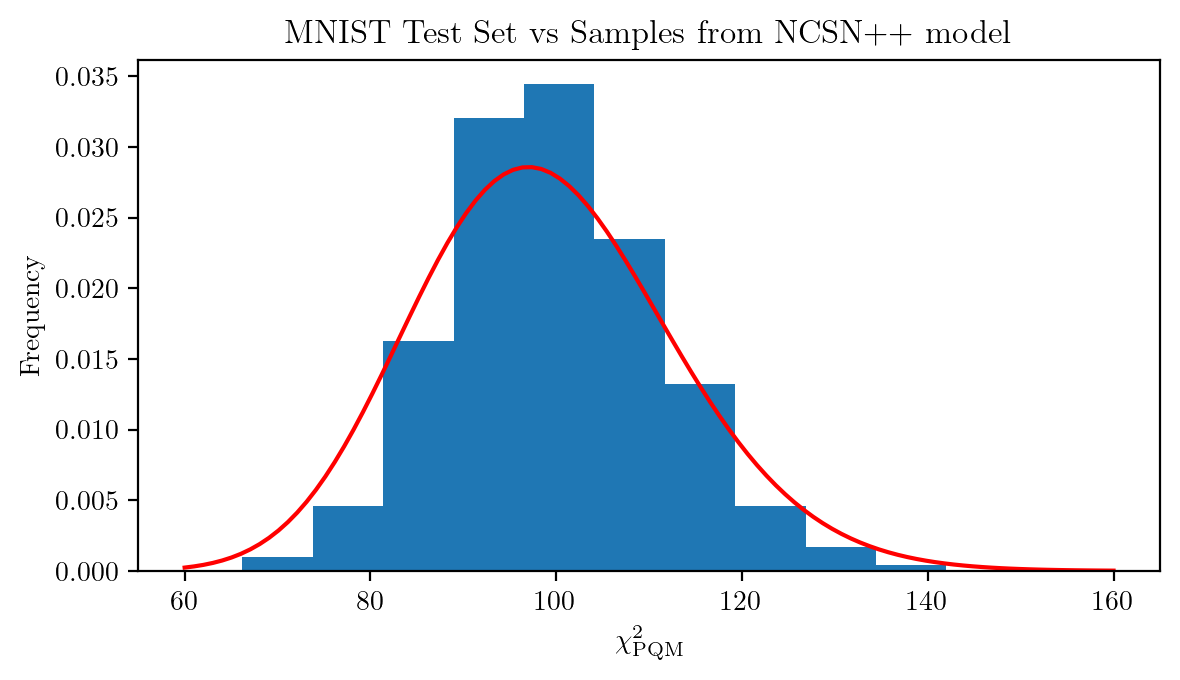

In [10]:
fig, ax = plt.subplots(figsize=(6, 3.5))
ax.hist(zs, bins=10, density=True)
ax.plot(np.linspace(60, 160, 100), chi2.pdf(np.linspace(60, 160, 100), df=99), color='red')
ax.set_xlabel(r'$\chi^2_{{\rm PQM}}$')
ax.set_ylabel('Frequency')
plt.title('MNIST Test Set vs Samples from NCSN++ model')
plt.tight_layout()
plt.show()